<h1>Part 1: Summary Statistics and Plots

<h3>Subpart 1: Profit Margins by Store

In [1]:
# Import data
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import pearsonr

data = pd.read_csv("data.csv").set_index(["Location number", "Month"])
data.head()

State  Gross revenue   Fixed cost  Variable cost  \
Location number Month                                                    
1               1        TX    48628171.02   9218156.69    24278189.23   
                2        TX    48107179.24  10587747.35    25116844.41   
                3        TX    64352278.29  10193873.77    33703499.83   
                4        TX    45943677.96   8764165.00    24037719.47   
                5        TX    32761434.98   8022116.43    16432119.18   

                       Rental cost  Number of products  Owned  
Location number Month                                          
1               1           365880                4452  False  
                2           365880                4452  False  
                3           365880                4452  False  
                4           365880                4452  False  
                5           365880                4452  False

In [2]:
# Sum revenues and costs across months
data_annual = data.groupby(["Location number", "State", "Number of products", "Owned"]).sum()
data_annual = data_annual.reset_index().set_index("Location number")
data_annual.head()

,State,Number of products,Owned,Gross revenue,Fixed cost,Variable cost,Rental cost
Location number,,,,,,,
1,TX,4452,False,5.447389e+08,1.108956e+08,2.793687e+08,4390560
2,TX,4502,False,3.559730e+08,7.287395e+07,1.937291e+08,783240
3,IL,4620,True,3.317718e+08,6.429775e+07,1.848279e+08,0
4,GA,4481,False,2.639843e+08,6.410409e+07,1.432398e+08,1696920
5,NJ,4533,False,1.890016e+08,4.475050e+07,1.037553e+08,894000


In [3]:
# Calculate annual profit margins, and find mean/median
data_annual["Profit margin"] = (data_annual["Gross revenue"] - data_annual["Fixed cost"] - data_annual["Variable cost"] - data_annual["Rental cost"]) / data_annual["Gross revenue"]
print("Mean annual profit margin: ", "{:2.2f}%".format(100 * data_annual["Profit margin"].mean()))
print("Median annual profit margin: ", "{:2.2f}%".format(100 * data_annual["Profit margin"].median()))

Mean annual profit margin:  24.86%
Median annual profit margin:  26.18%


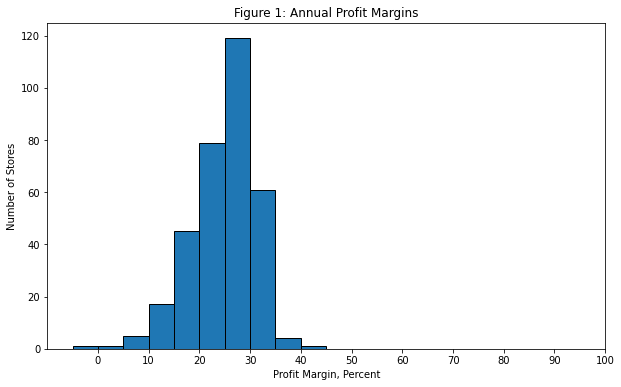

In [4]:
# Plot histogram of annual profit margins
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(100 * data_annual["Profit margin"], bins = range(-5, 100, 5), edgecolor='black')
ax.set_xticks(range(0, 101, 10))
ax.set_title("Figure 1: Annual Profit Margins")
ax.set_xlabel("Profit Margin, Percent")
ax.set_ylabel("Number of Stores")
plt.show()

While the distribution of annual profit margins does have a clear peak, it is somewhat skewed left. This is also reflected by the fact that the mean is slightly less than the median. Still, the profit margins across locations look reasonably normally distributed. 

It is to be expected that the profit margins are bound between 0 and 50%. Even a highly profitable store is unable to generate revenue without incurring corresponding costs; hence, no stores have a profit margin above 50%, and very few have a profit margin above 35%. On the other hand, the least profitable stores are likely to be closed; indeed, we see that only one store has a negative profit margin, and very few have a profit margin below 10%. These factors likely contribute to the Gaussian shape of the distribution.

<h3>Subpart 2: Aggregate Revenue

In [5]:
# Sum revenues and costs across stores
data_aggregate_monthly = data.groupby("Month").sum()
data_aggregate_monthly.head()

,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned
Month,,,,,,
1,9.304129e+09,2.069499e+09,4.943004e+09,49191170,1502156,36
2,9.786843e+09,1.964354e+09,5.180280e+09,49191170,1502156,36
3,1.158736e+10,2.296857e+09,6.126065e+09,49191170,1502156,36
4,9.105208e+09,1.915483e+09,4.754642e+09,49191170,1502156,36
5,9.347461e+09,1.877253e+09,4.860179e+09,49191170,1502156,36


In [6]:
# Combine months into quarters
data_aggregate_quarterly = data_aggregate_monthly.copy()
data_aggregate_quarterly.insert(0, "Quarter", [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4])
data_aggregate_quarterly = data_aggregate_quarterly.groupby("Quarter").sum()
data_aggregate_quarterly.head()

,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned
Quarter,,,,,,
1,3.067833e+10,6.330709e+09,1.624935e+10,147573510,4506468,108
2,2.975031e+10,6.168927e+09,1.546212e+10,147573510,4506468,108
3,2.988107e+10,6.241126e+09,1.536014e+10,147573510,4506468,108
4,2.993717e+10,6.227698e+09,1.583052e+10,147573510,4506468,108


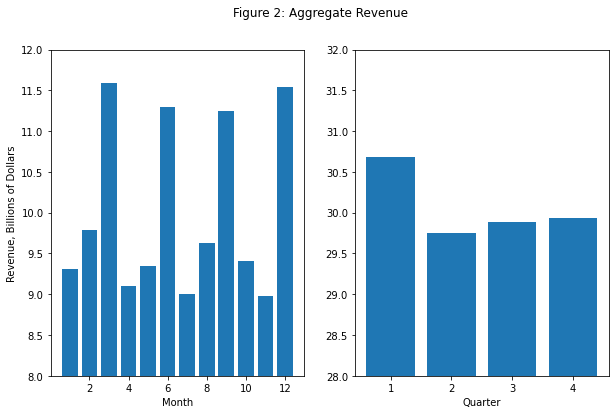

In [7]:
# Visualize monthly and quarterly aggregate revenue
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(10,6))
plt.suptitle("Figure 2: Aggregate Revenue")
ax1.set_ylabel("Revenue, Billions of Dollars")

ax1.bar(data_aggregate_monthly.index, data_aggregate_monthly["Gross revenue"] / 10 ** 9)
ax1.set_ylim(8, 12)
ax1.set_xlabel("Month")

ax2.bar(data_aggregate_quarterly.index, data_aggregate_quarterly["Gross revenue"] / 10 ** 9)
ax2.set_ylim(28, 32)
ax2.set_xlabel("Quarter")

plt.show()

Note that we are assuming use of monthly and quarterly aggregate *gross* revenue, so costs are not subtracted out.

<h1>Part 2: Data Cleaning

In [8]:
# Ensure that all owned stores are in states where there are also leased stores
data_leased = data[~data["Owned"]].copy()
data_owned = data[data["Owned"]].copy()
print(sorted(data_leased["State"].unique()))
print(sorted(data_owned["State"].unique()))

['CA', 'CO', 'GA', 'IL', 'NJ', 'TX', 'WA']
['CA', 'CO', 'GA', 'IL', 'NJ', 'TX', 'WA']


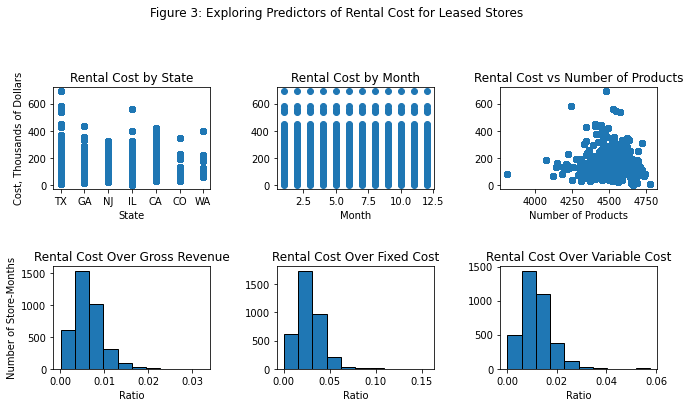

In [9]:
# Explore different possible predictors of rental cost
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(10,6))
plt.suptitle("Figure 3: Exploring Predictors of Rental Cost for Leased Stores")

axs[0, 0].scatter(data_leased["State"], data_leased["Rental cost"] / 1000)
axs[0, 0].set_title("Rental Cost by State")
axs[0, 0].set_ylabel("Cost, Thousands of Dollars")
axs[0, 0].set_xlabel("State")

axs[0, 1].scatter(data_leased.index.get_level_values("Month"), data_leased["Rental cost"] / 1000)
axs[0, 1].set_title("Rental Cost by Month")
axs[0, 1].set_xlabel("Month")

axs[0, 2].scatter(data_leased["Number of products"], data_leased["Rental cost"] / 1000)
axs[0, 2].set_title("Rental Cost vs Number of Products")
axs[0, 2].set_xlabel("Number of Products")

axs[1, 0].hist(data_leased["Rental cost"] / data_leased["Gross revenue"], edgecolor='black')
axs[1, 0].set_title("Rental Cost Over Gross Revenue")
axs[1, 0].set_ylabel("Number of Store-Months")
axs[1, 0].set_xlabel("Ratio")

axs[1, 1].hist(data_leased["Rental cost"] / data_leased["Fixed cost"], edgecolor='black')
axs[1, 1].set_title("Rental Cost Over Fixed Cost")
axs[1, 1].set_xlabel("Ratio")

axs[1, 2].hist(data_leased["Rental cost"] / data_leased["Variable cost"], edgecolor='black')
axs[1, 2].set_title("Rental Cost Over Variable Cost")
axs[1, 2].set_xlabel("Ratio")

fig.tight_layout(pad = 3)
plt.show()

Notice that rental costs appear to vary by state (though the range is extensive), but the relationship between rental cost and number of products is highly unclear. Furthermore, while there may be valuable information in the ratio of rental cost to other store metrics, using gross revenue, fixed cost, and variable cost, as that metric all appear to yield similar results. Finally, rental costs are constant each month.

As such, we will impute projected monthly rental costs for owned locations as the mean monthly gross revenue for the owned location, multiplied by the median ratio of monthly rental cost to mean gross revenue for leased stores in the state.

In [10]:
# Calculate median monthly rental cost to mean gross revenue ratios for each state
data_leased = data_leased.groupby(["Location number", "State"]).mean()
data_leased["Ratio"] = data_leased["Rental cost"] / data_leased["Gross revenue"]
data_leased = data_leased.groupby("State").median()
data_leased.head()

,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned,Ratio
State,,,,,,,
CA,2.689431e+07,5.524292e+06,1.378571e+07,139615,4491,False,0.006203
CO,2.670831e+07,5.912333e+06,1.470574e+07,135750,4511,False,0.004982
GA,2.202021e+07,5.173485e+06,1.202373e+07,134910,4502,False,0.005641
IL,2.403461e+07,5.468111e+06,1.313542e+07,140265,4516,False,0.006114
NJ,2.237595e+07,5.121991e+06,1.270802e+07,146390,4505,False,0.006744


In [11]:
# Calculate mean monthly gross revenues for owned stores
data_owned = data_owned.groupby("Location number").mean()
data_owned.head()

,Gross revenue,Fixed cost,Variable cost,Rental cost,Number of products,Owned
Location number,,,,,,
3,2.764765e+07,5.358146e+06,1.540232e+07,0,4620,True
9,6.774316e+07,1.169296e+07,3.150183e+07,0,4789,True
11,2.571321e+07,5.376977e+06,1.393406e+07,0,4568,True
21,2.663192e+07,5.415316e+06,1.363053e+07,0,4594,True
31,3.016265e+07,5.271787e+06,1.575493e+07,0,4666,True


In [12]:
# Impute rental costs for owned stores using the ratio above
data_imputed = data.copy()
data_imputed["Rental cost"] = data_imputed.apply(
    lambda row: data_owned.loc[row.name[0], "Gross revenue"] * data_leased.loc[row["State"], "Ratio"] if row["Owned"] else row["Rental cost"],
    axis=1
)
data_imputed.loc[data_imputed["Owned"]].head()

State  Gross revenue  Fixed cost  Variable cost  \
Location number Month                                                   
3               1        IL    30791018.69  6123108.00    17948338.14   
                2        IL    23805331.16  5014361.53    13051817.38   
                3        IL    33916624.99  6043273.71    19190769.99   
                4        IL    24170582.83  5196755.17    13505396.58   
                5        IL    24925332.00  4688566.82    14531349.44   

                        Rental cost  Number of products  Owned  
Location number Month                                           
3               1      169040.84003                4620   True  
                2      169040.84003                4620   True  
                3      169040.84003                4620   True  
                4      169040.84003                4620   True  
                5      169040.84003                4620   True

In [13]:
# Sum revenues and costs across months again
data_imputed_annual = data_imputed.groupby(["Location number", "State", "Number of products", "Owned"]).sum()
data_imputed_annual = data_imputed_annual.reset_index().set_index("Location number")
data_imputed_annual.head()

,State,Number of products,Owned,Gross revenue,Fixed cost,Variable cost,Rental cost
Location number,,,,,,,
1,TX,4452,False,5.447389e+08,1.108956e+08,2.793687e+08,4.390560e+06
2,TX,4502,False,3.559730e+08,7.287395e+07,1.937291e+08,7.832400e+05
3,IL,4620,True,3.317718e+08,6.429775e+07,1.848279e+08,2.028490e+06
4,GA,4481,False,2.639843e+08,6.410409e+07,1.432398e+08,1.696920e+06
5,NJ,4533,False,1.890016e+08,4.475050e+07,1.037553e+08,8.940000e+05


In [14]:
# Recalculate rent-adjusted annual profit margins, and find mean/median
data_imputed_annual["Profit margin"] = (data_imputed_annual["Gross revenue"] - data_imputed_annual["Fixed cost"] - data_imputed_annual["Variable cost"] - data_imputed_annual["Rental cost"]) / data_imputed_annual["Gross revenue"]
print("Mean annual projected rent-adjusted profit margin: ", "{:2.2f}%".format(100 * data_imputed_annual["Profit margin"].mean()))
print("Median annual projected rent-adjusted profit margin: ", "{:2.2f}%".format(100 * data_imputed_annual["Profit margin"].median()))

Mean annual projected rent-adjusted profit margin:  24.80%
Median annual projected rent-adjusted profit margin:  26.12%


In [21]:
# Check to see whether our imputed values would match well with actual rental costs for leased locations
rent_actual = data.loc[~data["Owned"], "Rental cost"].groupby("Location number").mean()

rent_imputed = data[~data["Owned"]].copy()
rent_imputed["Rental cost"] = rent_imputed.apply(
    lambda row: rent_imputed.loc[row.name[0], "Gross revenue"] * data_leased.loc[row["State"], "Ratio"],
    axis=1
)
rent_imputed = rent_imputed["Rental cost"].groupby("Location number").mean()

Location number
1    365880
2     65270
4    141410
5     74500
6     32790
Name: Rental cost, dtype: int64
Location number
1    251822.990012
2    136183.888594
4    131614.622583
5     77230.649764
6     68806.780141
Name: Rental cost, dtype: float64


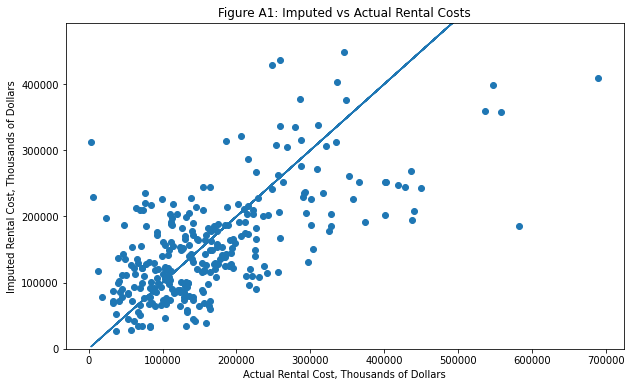

In [28]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(rent_actual, rent_imputed)
ax.plot(rent_actual, rent_actual)

ax.set_ylim(0, rent_imputed.max() * 1.1)
ax.set_title("Figure A1: Imputed vs Actual Rental Costs")
ax.set_xlabel("Actual Rental Cost, Thousands of Dollars")
ax.set_ylabel("Imputed Rental Cost, Thousands of Dollars")

plt.show()

<h1>Part 3: Drivers of Success

<h3>Linear Regression with Store Characteristics

In [15]:
# Calculate monthly profit and profit margin for each store
data_linreg = data_imputed.copy()
data_linreg["Profit"] = data_linreg["Gross revenue"] - data_linreg["Fixed cost"] - data_linreg["Variable cost"] - data_linreg["Rental cost"]
data_linreg["Profit margin"] = data_linreg["Profit"] / data_linreg["Gross revenue"]
data_linreg.head()

State  Gross revenue   Fixed cost  Variable cost  \
Location number Month                                                    
1               1        TX    48628171.02   9218156.69    24278189.23   
                2        TX    48107179.24  10587747.35    25116844.41   
                3        TX    64352278.29  10193873.77    33703499.83   
                4        TX    45943677.96   8764165.00    24037719.47   
                5        TX    32761434.98   8022116.43    16432119.18   

                       Rental cost  Number of products  Owned       Profit  \
Location number Month                                                        
1               1         365880.0                4452  False  14765945.10   
                2         365880.0                4452  False  12036707.48   
                3         365880.0                4452  False  20089024.69   
                4         365880.0                4452  False  12775913.49   
                5         365880.0                4452  False   7941319.37   

                       Profit margin  
Location number Month                 
1               1           0.303650  
                2           0.250206  
                3           0.312173  
                4           0.278078  
                5           0.242398

In [16]:
# Normalize numeric data and one-hot encode categorical data 
data_linreg_numeric = data_linreg.reset_index()["Number of products"]
data_linreg_categorical = data_linreg.reset_index()[["Month", "State", "Owned"]]

data_linreg_numeric = data_linreg.reset_index()["Number of products"]
data_linreg_numeric = (data_linreg_numeric - data_linreg_numeric.mean()) / data_linreg_numeric.std()

onehot = OneHotEncoder(sparse = False)
data_linreg_onehot = pd.DataFrame(onehot.fit_transform(data_linreg_categorical))
data_linreg_onehot.columns = onehot.get_feature_names(data_linreg_categorical.columns)

data_linreg_combined = pd.concat([data_linreg_numeric, data_linreg_onehot], axis = 1).drop(["Month_1", "State_NJ", "Owned_True"], axis = 1)
data_linreg_combined.head()

,Number of products,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,State_CA,State_CO,State_GA,State_IL,State_TX,State_WA,Owned_False
0,-0.436305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,-0.436305,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,-0.436305,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,-0.436305,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,-0.436305,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [17]:
# Run linear regression and display coefficients
linreg = linear_model.LinearRegression()
linreg.fit(data_linreg_combined, data_linreg["Profit margin"])
print("Intercept: ", "{:.4f}".format(linreg.intercept_))
for i in range(linreg.coef_.size):
    print(data_linreg_combined.columns[i], ": ", "{:.4f}".format(linreg.coef_[i]))

Intercept:  0.1329
Number of products :  0.0570
Month_2 :  0.0292
Month_3 :  0.0323
Month_4 :  0.0197
Month_5 :  0.0339
Month_6 :  0.0269
Month_7 :  0.0242
Month_8 :  0.0411
Month_9 :  0.0342
Month_10 :  0.0288
Month_11 :  0.0125
Month_12 :  0.0218
State_CA :  0.0606
State_CO :  0.0504
State_GA :  0.0057
State_IL :  0.0476
State_TX :  0.0796
State_WA :  0.0628
Owned_False :  0.0394


Differences in profit margin by month and state are apparent: January is the worst month for profit margin, while August is the best. Similarly, New Jersey is the worst state to be located in, while Texas is the best. Additionally, we can see that leasing a store (instead of owning one) and having more products corresponds to better profit margins. Of course, these cannot be shown to be causal relationships in this analysis.

Note that to ensure linear independence, for each one-hot encoded variable, a column was dropped. We are still able to make predictions for all scenarios, however. For instance, using only the intercept and the number of products term, we would obtain the expected profit margin for the month of January for an owned stores in New Jersey.

<h3>Financial Contributors to Profit Margin

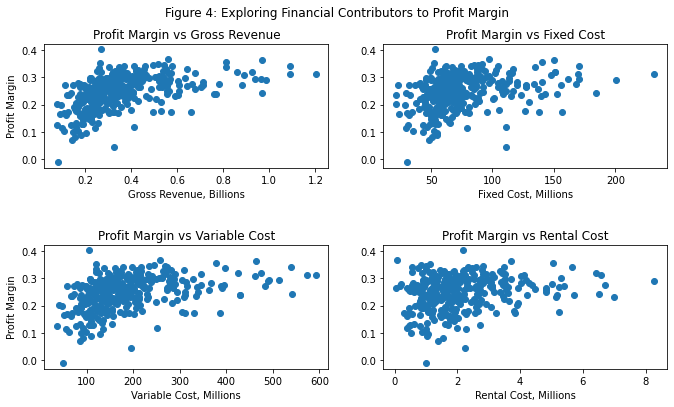

In [18]:
# Explore different possible financial contributors to profit margin
fig, ax = plt.subplots(figsize=(10,6))
plt.suptitle("Figure 4: Exploring Financial Contributors to Profit Margin")

axs[0, 0].scatter(data_imputed_annual["Gross revenue"] / 1000000000, data_imputed_annual["Profit margin"])
axs[0, 0].set_title("Profit Margin vs Gross Revenue")
axs[0, 0].set_ylabel("Profit Margin")
axs[0, 0].set_xlabel("Gross Revenue, Billions")

axs[0, 1].scatter(data_imputed_annual["Fixed cost"] / 1000000, data_imputed_annual["Profit margin"])
axs[0, 1].set_title("Profit Margin vs Fixed Cost")
axs[0, 1].set_xlabel("Fixed Cost, Millions")

axs[1, 0].scatter(data_imputed_annual["Variable cost"] / 1000000, data_imputed_annual["Profit margin"])
axs[1, 0].set_title("Profit Margin vs Variable Cost")
axs[1, 0].set_ylabel("Profit Margin")
axs[1, 0].set_xlabel("Variable Cost, Millions")

axs[1, 1].scatter(data_imputed_annual["Rental cost"] / 1000000, data_imputed_annual["Profit margin"])
axs[1, 1].set_title("Profit Margin vs Rental Cost")
axs[1, 1].set_xlabel("Rental Cost, Millions")

fig.tight_layout(pad = 3)
plt.show()

As would be expected due to higher variability when both revenues and costs are low, there is a large spread in profit margin for these relatively low-revenue, low-cost (we will call them "small") stores. To improve profit margin for other such stores, it will be valuable to examine characteristics of top-performing small stores. 

It is important to note that profit margins are positively correlated with all three costs, as well as gross revenue. This may be unexpected; it could certainly have been the case that low fixed, variable, or rental costs are the primary reason for high profit margins (in which case profit margins and costs would be negatively correlated). Instead, we may hypothesize that costs are highly correlated with gross revenue; this is verified in the following section. It is therefore insufficient to simply say that a solution to achieve higher profit margins is to cut costs across the board.

Figure 4 also shows another insight: the relatively high-revenue, high-cost (we will call them "large") stores generally see a high profit margin with limited spread. This is a non-obvious result. We might expect to see lower variability in the profit margin for large stores, in the vein of the law of large numbers, but there are many possible diseconomies of scale. 

Rather than focusing on these diseconomies of scale, our results indicate that we should instead consider reasons why large stores typically see high profit margins, and grow high-potential stores accordingly. For instance, if a small store with a high profit margin is unlikely to improve much by expanding, but a poorly-performing peer could increase its profit margin significantly, then it would be best to invest in and grow the latter.

<h3>Decoupling Gross Revenue and Cost

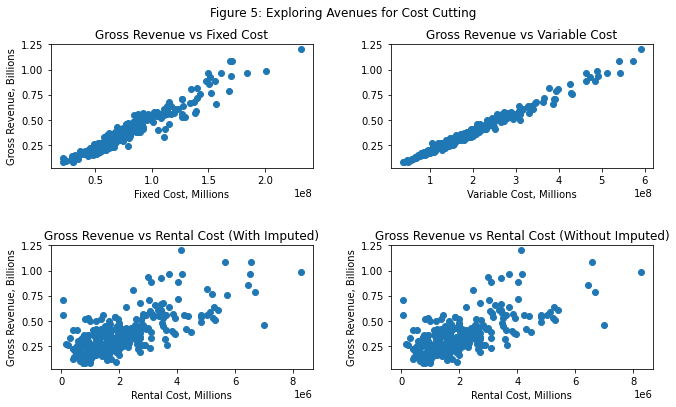

In [19]:
# Explore how different costs correlate with gross revenue
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(10,6))
plt.suptitle("Figure 5: Exploring Avenues for Cost Cutting")

axs[0, 0].scatter(data_imputed_annual["Fixed cost"], data_imputed_annual["Gross revenue"] / 1000000000)
axs[0, 0].set_title("Gross Revenue vs Fixed Cost")
axs[0, 0].set_ylabel("Gross Revenue, Billions")
axs[0, 0].set_xlabel("Fixed Cost, Millions")

axs[0, 1].scatter(data_imputed_annual["Variable cost"], data_imputed_annual["Gross revenue"] / 1000000000)
axs[0, 1].set_title("Gross Revenue vs Variable Cost")
axs[0, 1].set_xlabel("Variable Cost, Millions")

axs[1, 0].scatter(data_imputed_annual["Rental cost"], data_imputed_annual["Gross revenue"] / 1000000000)
axs[1, 0].set_title("Gross Revenue vs Rental Cost (With Imputed)")
axs[1, 0].set_ylabel("Gross Revenue, Billions")
axs[1, 0].set_xlabel("Rental Cost, Millions")

axs[1, 1].scatter(data_annual.loc[~data_annual["Owned"], "Rental cost"], data_annual.loc[~data_annual["Owned"], "Gross revenue"] / 1000000000)
axs[1, 1].set_title("Gross Revenue vs Rental Cost (Without Imputed)")
axs[1, 1].set_ylabel("Gross Revenue, Billions")
axs[1, 1].set_xlabel("Rental Cost, Millions")

fig.tight_layout(pad = 3)
plt.show()

In [20]:
corr_fc, _ = pearsonr(data_imputed_annual["Fixed cost"], data_imputed_annual["Gross revenue"])
corr_vc, _ = pearsonr(data_imputed_annual["Variable cost"], data_imputed_annual["Gross revenue"])
corr_rci, _ = pearsonr(data_imputed_annual["Rental cost"], data_imputed_annual["Gross revenue"])
corr_rc, _ = pearsonr(data_annual.loc[~data_annual["Owned"], "Rental cost"], data_annual.loc[~data_annual["Owned"], "Gross revenue"])

print("Correlation with Gross Revenue")
print("Fixed Cost: ", "{:.4f}".format(corr_fc))
print("Variable Cost: ", "{:.4f}".format(corr_vc))
print("Rental Cost (With Imputed): ", "{:.4f}".format(corr_rci))
print("Rental Cost (Without Imputed): ", "{:.4f}".format(corr_rc))

Correlation with Gross Revenue
Fixed Cost:  0.9602
Variable Cost:  0.9915
Rental Cost (With Imputed):  0.7047
Rental Cost (Without Imputed):  0.6561


As discussed in the above section, we can quickly see that gross revenue is highly correlated with cost. However, we can take advantage of the fact that these correlations vary significantly for the different kinds of costs. In particular, the correlation between rental cost and gross revenue is only about 0.66 when ignoring imputed values, which is far lower than the fixed cost and variable cost correlations (both exceed 0.95). As such, a promising way to achieve lower costs without cutting into gross revenue is by leasing stores where the rental cost is low. 

It should be noted, however, that this insight is only useful in the context of opening new stores or closing existing ones; it may be difficult or impossible to lower an existing rental cost. Furthermore, rental costs are generally about two orders of magnitude less than fixed and variable costs each month. As such, if it is necessary to attempt to reduce costs through other avenues, we should prioritize finding reductions in fixed cost, rather than variable cost, since the latter is so highly correlated with gross revenue. If this information is available, it would be valuable to examine the components of the fixed and variable costs, so as to better determine what cost savings can actually yield a higher profit margin.

<h3>Characteristics of Top Performers

In [21]:
# Output descriptive statistics for all stores
print(data_imputed_annual["State"].value_counts())
print(data_imputed_annual["Owned"].value_counts())
data_imputed_annual.describe(include = "all", percentiles = [0.5]).drop(["count", "std"])

TX    101
CA     63
GA     54
IL     54
NJ     32
CO     15
WA     14
Name: State, dtype: int64
False    297
True      36
Name: Owned, dtype: int64


,State,Number of products,Owned,Gross revenue,Fixed cost,Variable cost,Rental cost,Profit margin
unique,7,NaN,2,NaN,NaN,NaN,NaN,NaN
top,TX,NaN,False,NaN,NaN,NaN,NaN,NaN
freq,101,NaN,297,NaN,NaN,NaN,NaN,NaN
mean,NaN,4510.978979,NaN,3.611018e+08,7.498036e+07,1.888953e+08,2.067726e+06,0.248004
min,NaN,3810.000000,NaN,7.820048e+07,2.136509e+07,3.669576e+07,4.104000e+04,-0.010842
50%,NaN,4527.000000,NaN,3.193804e+08,6.757105e+07,1.656653e+08,1.769664e+06,0.261160
max,NaN,4789.000000,NaN,1.200481e+09,2.317061e+08,5.915411e+08,8.277000e+06,0.402023


In [22]:
# Output descriptive statistics for worst performing stores
data_imputed_annual_bot = data_imputed_annual.loc[data_annual["Profit margin"] <= data_imputed_annual["Profit margin"].quantile(0.1)]
print(sorted(data_imputed_annual_bot["State"].unique()))
data_imputed_annual_bot.describe(include = 'all', percentiles = [0.5]).drop(["count", "std"])

['CA', 'GA', 'IL', 'NJ', 'TX', 'WA']


,State,Number of products,Owned,Gross revenue,Fixed cost,Variable cost,Rental cost,Profit margin
unique,6,NaN,1,NaN,NaN,NaN,NaN,NaN
top,GA,NaN,False,NaN,NaN,NaN,NaN,NaN
freq,14,NaN,34,NaN,NaN,NaN,NaN,NaN
mean,NaN,4291.676471,NaN,1.877916e+08,5.400383e+07,1.087755e+08,1.318066e+06,0.124275
min,NaN,3810.000000,NaN,7.820048e+07,2.417270e+07,3.669576e+07,3.934800e+05,-0.010842
50%,NaN,4317.500000,NaN,1.861473e+08,5.280059e+07,1.083681e+08,1.318440e+06,0.128098
max,NaN,4475.000000,NaN,4.116247e+08,1.114032e+08,2.516392e+08,2.720640e+06,0.166986


In [23]:
# Output descriptive statistics for top performing stores
data_imputed_annual_top = data_imputed_annual.loc[data_imputed_annual["Profit margin"] >= data_imputed_annual["Profit margin"].quantile(0.9)]
print(sorted(data_imputed_annual_top["State"].unique()))
data_imputed_annual_top.describe(include = "all", percentiles = [0.5]).drop(["count", "std"])

['CA', 'IL', 'TX', 'WA']


,State,Number of products,Owned,Gross revenue,Fixed cost,Variable cost,Rental cost,Profit margin
unique,4,NaN,2,NaN,NaN,NaN,NaN,NaN
top,TX,NaN,False,NaN,NaN,NaN,NaN,NaN
freq,18,NaN,29,NaN,NaN,NaN,NaN,NaN
mean,NaN,4672.235294,NaN,5.023040e+08,8.857872e+07,2.420358e+08,2.190649e+06,0.336690
min,NaN,4544.000000,NaN,2.512116e+08,4.914917e+07,1.058644e+08,6.240000e+04,0.318307
50%,NaN,4676.000000,NaN,4.408740e+08,7.988978e+07,2.129589e+08,2.035500e+06,0.332582
max,NaN,4789.000000,NaN,1.088825e+09,1.706193e+08,5.395776e+08,6.430920e+06,0.402023


In [24]:
# Verify that low rental costs among top performing stores weren't imputed
data_annual.loc[~data_annual["Owned"] & data_annual["Profit margin"] >= data_annual["Profit margin"].quantile(0.9), "Rental cost"].describe()

count    2.970000e+02
mean     1.987522e+06
std      1.274057e+06
min      4.104000e+04
25%      1.114440e+06
50%      1.687080e+06
75%      2.544360e+06
max      8.277000e+06
Name: Rental cost, dtype: float64

Lastly, we can gain some insight simply by comparing the top performing and worst performing stores, as well as the set of all stores across the United States. Beginning with the categorical variables, we see that of the 36 owned stores, 5 are in the top 10% for profit margin, while none are in the bottom 10%. This is not necessarily indicative of owning a store leading to better profit margins; in fact, our linear regression from earlier predicts a 0.0394 higher profit margin from leasing a store. Instead, it may be the case that only strong stores are purchased rather than leased, perhaps because owning a store is a longer-term commitment that is only undertaken if it performs well.

Considering the different states stores are located in, we can see that California, Illinois, Texas, and Washington are represented in both the top and bottom 10% of stores. This is not particularly informative in terms of deciding where to locate a new store, and more detailed location data would likely be helpful. On the other hand, New Jersey and Georgia are represented only in the bottom 10%, with Georgia even claiming 14 of the 34 worst performing stores. This corresponds to the low coefficients on these two states from our linear regression; without further analysis, it would be needlessly risky to invest further in new stores in these states.

Looking at the financial data, we can verify that both higher revenues and higher costs correspond to better profit margins. This is evidenced by the higher mean and median for these columns among the top performing stores, as compared to the set of all stores and the worst performing stores. However, we also see that some of the top performing stores had rental costs below those of even the worst performing stores; it is verified that these are not just imputed values. This supports the hypothesis that improvements to profit margins can be achieved through low rental costs.

Finally, considering the number of products sold by each store, it is valuable to note that even the minimum number of products sold by a store in the top 10% exceeds the maximum number of a store in the bottom 10%. This property does not hold for any of the other numeric columns. While this does not mean that increasing the number of products sold will cause a better profit margin for all stores, it may indicate that having a larger number of products is necessary to possibly achieve top performance.